# COMP3221 - Distributed Systems 

## Week 6 - Tutorial - Federated Learning

**Objectives:**

* To understand the basics of federated learning algorithm (FedAvg)
* Using Pytorch to implement a federated learning system

**Instructions:**
* Exercises tend to be completed by **Python 3** programming language.
* You can either use IPython notebook or just python files to finish the exercises. 
* To install IPython notebooks and Python 3, you can: 
   * Use IPython 3 (Jupyter) notebook installed on your computer: http://jupyter.org/install (you need to have Python installed first: https://docs.python.org/3/using/index.html )
   * Use Web-based IPython notebooks such as Google Colaboratory: https://colab.research.google.com/   
* Using the IPython notebook:
  * If you are using Jupyter intalled on your computer, Go to *File -> Open*. Drag and drop the "*.ipynb*" file to the home interface and click upload. 
  * If you are using Google Colaboratory, Click *File -> Upload notebook*, and upload the "*.ipynb*" file.
  * To run the code cells you can press *Ctrl-Enter* or hit the *Play* button at the top.
* Using python files:
  * We recommend using Visual Studio Code as IDE: https://code.visualstudio.com/
  
* Please complete all exercises marked with **TODO**.
* Make sure to save your files when you are done with the exercises, so you can show your tutor next week.

In this tutorial we will use **pytorch** to implement federated learning.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json
import copy
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt

### 1. Ferated learning

#### 1.1 MNIST Dataset
A handwritten digits dataset including 70,000 samples belonging to 10 classes (from 0 to 9). The original dataset has been distributed to 5 clients where each client has different data sizes and has only 3 over 10 classes.

**Let's load an dataset of one client**

In [2]:
def get_data(id=""):
    train_path = os.path.join("FLdata", "train", "mnist_train_client" + str(id) + ".json")
    test_path = os.path.join("FLdata", "test", "mnist_test_client" + str(id) + ".json")
    train_data = {}
    test_data = {}

    with open(os.path.join(train_path), "r") as f_train:
        train = json.load(f_train)
        train_data.update(train['user_data'])
    with open(os.path.join(test_path), "r") as f_test:
        test = json.load(f_test)
        test_data.update(test['user_data'])

    X_train, y_train, X_test, y_test = train_data['0']['x'], train_data['0']['y'], test_data['0']['x'], test_data['0']['y']
    X_train = torch.Tensor(X_train).view(-1, 1, 28, 28).type(torch.float32)
    y_train = torch.Tensor(y_train).type(torch.int64)
    X_test = torch.Tensor(X_test).view(-1, 1, 28, 28).type(torch.float32)
    y_test = torch.Tensor(y_test).type(torch.int64)
    train_samples, test_samples = len(y_train), len(y_test)
    return X_train, y_train, X_test, y_test, train_samples, test_samples

In [3]:
client_id = 1
X_train, y_train, X_test, y_test, _, _= get_data(client_id)

**Preview some data examples from client 1**

(28, 28)
label: tensor(1)


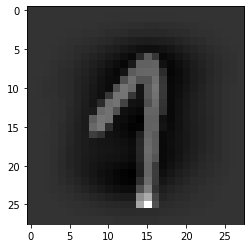

In [4]:
image = X_train[0].numpy().reshape(28,28)
print(image.shape)
plt.imshow(image, cmap='gray')
print("label:",y_train[0])

(28, 28)
label: tensor(2)


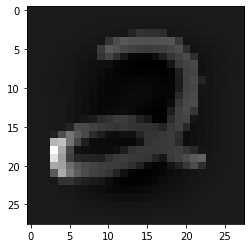

In [5]:
image = X_train[1].numpy().reshape(28,28)
print(image.shape)
plt.imshow(image, cmap='gray')
print("label:",y_train[1])

### 1.2 Machine learning model

Each client will perform a classification. Each client needs to classify 3 classes, we use multinomial logistic regression. The definition of the model is defined as follows:

In [6]:
class MCLR(nn.Module):
    def __init__(self):
        super(MCLR, self).__init__()
        # Create a linear transformation to the incoming data
        # Input dimension: 784 (28 x 28), Output dimension: 10 (10 classes)
        self.fc1 = nn.Linear(784, 10)

    # Define how the model is going to be run, from input to output
    def forward(self, x):
        # Flattens input by reshaping it into a one-dimensional tensor. 
        x = torch.flatten(x, 1)
        # Apply linear transformation
        x = self.fc1(x)
        # Apply a softmax followed by a logarithm
        output = F.log_softmax(x, dim=1)
        return output

### 1.3 Federated learning algorithms
![title](Algorithms.png)

### 1.4 Define Client

Each client has 3 main functions.
- **set_parameters**: receive a global model from the server, replace its local model with the global model.
- **train**: using the new global model to continue training to obtain a new local model.
- **test**: evaluate the global model receiving from the server.

In [10]:
class UserAVG():
    def __init__(self, client_id, model, learning_rate, batch_size):

        self.X_train, self.y_train, self.X_test, self.y_test, self.train_samples, self.test_samples = get_data(client_id)
        self.train_data = [(x, y) for x, y in zip(self.X_train, self.y_train)]
        self.test_data = [(x, y) for x, y in zip(self.X_test, self.y_test)]
        self.trainloader = DataLoader(self.train_data, self.train_samples)
        self.testloader = DataLoader(self.test_data, self.test_samples)

        self.loss = nn.NLLLoss()

        self.model = copy.deepcopy(model)

        self.id = client_id

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        
    def set_parameters(self, model):
        for old_param, new_param in zip(self.model.parameters(), model.parameters()):
            old_param.data = new_param.data.clone()
            
    def train(self, epochs):
        LOSS = 0
        self.model.train()
        for epoch in range(1, epochs + 1):
            self.model.train()
            for batch_idx, (X, y) in enumerate(self.trainloader):
                self.optimizer.zero_grad()
                print(len(X))
                output = self.model(X)
                loss = self.loss(output, y)
                loss.backward()
                self.optimizer.step()
        return loss.data
    
    def test(self):
        self.model.eval()
        test_acc = 0
        for x, y in self.testloader:
            output = self.model(x)
            test_acc += (torch.sum(torch.argmax(output, dim=1) == y) * 1. / y.shape[0]).item()
            print(str(self.id) + ", Accuracy of client ",self.id, " is: ", test_acc)
        return test_acc

### 1.4 Define Server

The server has 3 main functions:
- **send_parameters**: broadcast the global model to all clients
- **aggregate_parameters**: aggregate new global model from local models of all clients.
- **evaluate**: evaluate the global model across all clients

In [11]:
def send_parameters(server_model, users):
    for user in users:
        user.set_parameters(server_model)

def aggregate_parameters(server_model, users, total_train_samples):
    # Clear global model before aggregation
    for param in server_model.parameters():
        param.data = torch.zeros_like(param.data)
        
    for user in users:
        for server_param, user_param in zip(server_model.parameters(), user.model.parameters()):
            server_param.data = server_param.data + user_param.data.clone() * user.train_samples / total_train_samples
    return server_model

def evaluate(user):
    total_accurancy = 0
    for user in users:
        total_accurancy += user.test()
    return total_accurancy/len(users)

### 1.5 Create a federated learning network with 5 clients

In [12]:
# Init parameters 
num_user = 5
users = []
server_model = MCLR()
batch_size = 20
learning_rate = 0.01
num_glob_iters = 100 # No. of global rounds

# TODO:  Create a federate learning network with 5 clients and append it to users list.
total_train_samples = 0
for i in range(1,num_user+1):
    user = UserAVG(i, server_model, learning_rate, batch_size)
    users.append(user)
    total_train_samples += user.train_samples
    send_parameters(server_model, users)

In [13]:
# Runing FedAvg
loss = []
acc = []

for glob_iter in range(num_glob_iters):
    
    
    # TODO: Broadcast global model to all clients
    send_parameters(server_model,users)
    
    # Evaluate the global model across all clients
    avg_acc = evaluate(users)
    acc.append(avg_acc)
    print("Global Round:", glob_iter + 1, "Average accuracy across all clients : ", avg_acc)
    
    # Each client keeps training process to  obtain new local model from the global model 
    avgLoss = 0
    for user in users:
        avgLoss += user.train(1)
    # Above process training all clients and all client paricipate to server, how can we just select subset of user for aggregation
    loss.append(avgLoss)
    
    # TODO:  Aggregate all clients model to obtain new global model 
    aggregate_parameters(server_model, users, total_train_samples)

1, Accuracy of client  1  is:  0.08800773322582245
2, Accuracy of client  2  is:  0.08800773322582245
3, Accuracy of client  3  is:  0.08800773322582245
4, Accuracy of client  4  is:  0.08800773322582245
5, Accuracy of client  5  is:  0.08800773322582245
Global Round: 1 Average accuracy across all clients :  0.08800773322582245
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

Plot average training loss across all clients during training

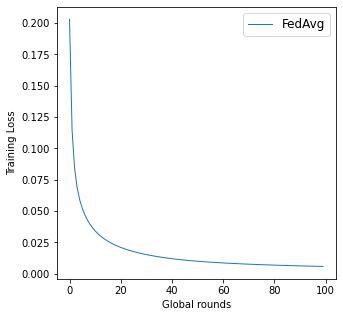

In [11]:
plt.figure(1,figsize=(5, 5))
plt.plot(loss, label="FedAvg", linewidth  = 1)
plt.legend(loc='upper right', prop={'size': 12}, ncol=2)
plt.ylabel('Training Loss')
plt.xlabel('Global rounds')
plt.show()

Plot average testing accuracy across all clients during training

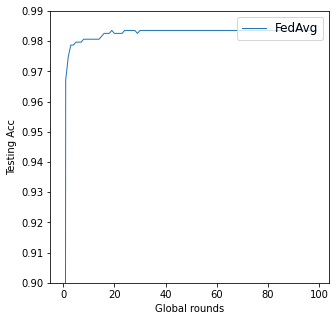

In [15]:
plt.figure(1,figsize=(5, 5))
plt.plot(acc, label="FedAvg", linewidth  = 1)
plt.ylim([0.9,  0.99])
plt.legend(loc='upper right', prop={'size': 12}, ncol=2)
plt.ylabel('Testing Acc')
plt.xlabel('Global rounds')
plt.show()